In [1]:
import numpy as np
import xarray as xr
import xgcm
# Suppress warning messages for a cleaner presentation
# import warnings
# warnings.filterwarnings('ignore')

## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.

import sys
sys.path.append('/home/jovyan/ECCOv4-py/ECCOv4-py')

import ecco_v4_py as ecco

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
from matplotlib import pyplot as plt
import cartopy as cart
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.Robinson(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)

        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax

## Connect to Dask Cluster

In [2]:
from dask_gateway import Gateway, GatewayCluster
gateway = Gateway()

In [3]:
gateway.list_clusters()

[]

In [4]:
cluster = GatewayCluster()
cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [5]:
gateway

Gateway<http://10.39.245.173:8000/services/dask-gateway>

In [6]:
cluster

In [7]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.2899235a769041688113812ccc236ba7 Dashboard: /services/dask-gateway/clusters/prod.2899235a769041688113812ccc236ba7/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Add relevant constants

In [8]:
base_dir = '/home/jovyan/'

In [9]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

## Load ECCOv4r3 data from catalog

In [10]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds0  = cat["ECCOv4r3"].to_dask()

In [11]:
# ECCO likes the 'tile' name, but data here saved as 'face'
ds0 = ds0.rename({'face':'tile'})

In [12]:
ds0#['time']

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13, time: 288, time_snp: 287)
Coordinates:
    Depth      (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    PHrefF     (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    XC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zp1        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drC        (k_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (tile, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dxG        (tile, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyC        (tile, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    dyG        (tile, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * tile       (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC      (k, tile, j, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacS      (k, tile, j_g, i) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
    hFacW      (k, tile, j, i_g) float32 dask.array<chunksize=(50, 13, 90, 90), meta=np.ndarray>
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter_snp   (time_snp) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    rA         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAs        (tile, j_g, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAw        (tile, j, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    rAz        (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Data variables:
    ADVr_SLT   (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_SLT   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVx_TH    (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_SLT   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_SLT   (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, tile, j, i) float32 das

In [63]:
# Set up plotting mapper
mapper = LLCMapper(ds)

In [13]:
#Volume (m^3)
vol = (ds0.rA*ds0.drF*ds0.hFacC).transpose('tile','k','j','i')

# Long method, from https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Heat_budget_closure.html

# Fast method (since on pangeo all data already like that)

In [14]:
year_start = 1993
year_end = 2015

ds = ds0[['ETAN_snp','THETA_snp','TFLUX','oceQsw','ADVx_TH','ADVy_TH','ADVr_TH',
                        'DFxE_TH','DFyE_TH','DFrE_TH','DFrI_TH']].sel(
    time_snp=slice('%i-01-01' % year_start,'%i-01-01' % year_end),time=slice('%i' % year_start,'%i' % (year_end - 1)))

## Create the xgcm 'grid' object

In [15]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [16]:
grid = ecco.get_llc_grid(ds)

## Number of seconds in each month



In [17]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

## Calculate total tendency of $\theta (G^\theta_{total})$

In [18]:
# Calculate the s*theta term
sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ds.Depth)

In [19]:
# Total tendency (degC/s)
G_total = grid.diff(sTHETA, 'T', boundary='fill', fill_value=0.0)/delta_t

#**Note**: Unlike the monthly snapshots ``ETAN_snp`` and ``THETA_snp``, 
#the resulting data array ``G_total`` has now the same time values as the time-mean 
# fields (middle of the month).

## Plot the time-mean $\partial \theta / \partial t$, total $\Delta \theta$, and one example $\partial \theta / \partial t$ field

### Time-mean $\partial \theta / \partial t$

### The time-mean $\partial \theta / \partial t$ (i.e., $\overline{G^{\theta}_\textrm{total}}$), is given by $\overline{G^{\theta}_\textrm{total}} = \sum_{i=1}^{nm} w_i G^{\theta}_\textrm{total}$ with $\sum_{i=1}^{nm} w_i = 1$ and nm=number of months

In [20]:
# The weights are just the number of seconds per month divided by total seconds
month_length_weights = delta_t / delta_t.sum()

In [21]:
# The weighted mean weights by the length of each month (in seconds)
G_total_mean = (G_total*month_length_weights).sum('time')

### Total $\Delta \theta$

How much did THETA change over the analysis period?

In [22]:
# The number of seconds in the entire period
seconds_in_entire_period = \
    float(ds.time_snp[-1] - ds.time_snp[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('Sum of seconds in each month ', delta_t.sum().values)

seconds in analysis period:  694224000.0
Sum of seconds in each month  694224000.0


In [23]:
THETA_delta = G_total_mean*seconds_in_entire_period

### Example $G^\theta_{total}$ field at a particular time

In [24]:
# get an array of YYYY, MM, DD, HH, MM, SS for
#dETAN_dT_perSec at time index 100
tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_total.time[100].values)
print(tmp)

(2001, 5, 15, 0, 0, 0)


## Calculate tendency due to advective convergence ($G^{\theta}_\textrm{advection}$)

### Horizontal convergence of advective heat flux

The relevant fields from the diagnostic output here are - ADVx_TH: U Component Advective Flux of Potential Temperature (degC m^3/s) - ADVy_TH: V Component Advective Flux of Potential Temperature (degC m^3/s)

The xgcm grid object is then used to take the convergence of the horizontal heat advection.

In [25]:
ADVxy_diff = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')

# Convergence of horizontal advection (degC m^3/s)
adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

In [26]:
# Load monthly averages of vertical advective flux
ADVr_TH = ds.ADVr_TH.transpose('time','tile','k_l','j','i')

### **Note**: For ``ADVr_TH``, ``DFrE_TH`` and ``DFrI_TH``, we need to make sure that 
### sequence of dimensions are consistent. When loading the fields use 
### ``.transpose('time','tile','k_l','j','i')``. 
### Otherwise, the divergences will be not correct (at least for ``tile = 12``).

In [27]:
# Convergence of vertical advection (degC m^3/s)
adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='fill')

#**Note**: In case of the volume budget (and salinity conservation), the surface forcing (``oceFWflx``) is already included at the top level (``k_l = 0``) in ``WVELMASS``. Thus, to keep the surface forcing term explicitly represented, one needs to zero out the values of ``WVELMASS`` at the surface so as to avoid double counting (see ``ECCO_v4_Volume_budget_closure.ipynb``). This is not the case for the heat budget. ``ADVr_TH`` does not include the sea surface forcing. Thus, the vertical
#advective flux (at the air-sea interface) should not be zeroed out.

## Total convergence of advective flux ($G^{\theta}_\textrm{advection}$)

In [28]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_advection = (adv_hConvH + adv_vConvH)/vol

## Plot the time-mean $G^{\theta}_\textrm{advection}$

In [29]:
G_advection_mean = (G_advection*month_length_weights).sum('time')


### Example $G^{\theta}_\textrm{advection}$ field at a particular time

In [30]:
tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_advection.time[100].values)
print(tmp)

(2001, 5, 15, 0, 0, 0)


## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)

### Horizontal convergence of diffusive heat flux

In [31]:
DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')

# Convergence of horizontal diffusion (degC m^3/s)
dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

# Vertical convergence of diffusive heat flux

In [32]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time','tile','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','tile','k_l','j','i')

# Convergence of vertical diffusion (degC m^3/s)
dif_vConvH = grid.diff(DFrE_TH, 'Z', boundary='fill') + grid.diff(DFrI_TH, 'Z', boundary='fill')

### Total convergence of diffusive flux ($G^{\theta}_\textrm{diffusion}$)

In [33]:
# Sum horizontal and vertical convergences and divide by volume (degC/s)
G_diffusion = (dif_hConvH + dif_vConvH)/vol

## Plot the time-mean $G^\theta_{diffusion}$

In [34]:
G_diffusion_mean = (G_diffusion*month_length_weights).sum('time')

## Calculate tendency due to forcing ($G^{\theta}_\textrm{forcing}$)

In [35]:
Z = ds.Z.load()
RF = np.concatenate([ds0.Zp1.values[:-1],[np.nan]])

### **Note**: ``Z`` and ``Zp1`` are used in deriving surface heat penetration. 
### MATLAB code uses ``RF`` from ``mygrid`` structure.

In [36]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [37]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [38]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

### Compute vertically penetrating flux

In [39]:
## Land masks
# Make copy of hFacC
mskC = ds.hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*ds.oceQsw).transpose('time','tile','k','j','i')

# Surface heat flux (W/m^2)
forcH_surf = ((ds.TFLUX - (1-(q1[0]-q2[0]))*ds.oceQsw)\
              *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')

# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','tile','k','j','i')

## Geothermal flux

In [40]:
geoflx_llc = ds0['GEOFLX']

In [41]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
GEOFLX = geoflx3d.transpose('k','tile','j','i')
GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

## Total forcing ($G^{\theta}_\textrm{forcing}$)

In [42]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ds.hFacC*ds.drF)

## Plot the time-mean $G^{\theta}_\textrm{forcing}$

In [43]:
G_forcing_mean = (G_forcing*month_length_weights).sum('time')

### Example $G^{\theta}_\textrm{forcing}$ field at a particular time

In [44]:
tmp = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(G_forcing.time[100].values)
print(tmp)

(2001, 5, 15, 0, 0, 0)


# Save to dataset

## Add all variables to a new dataset

In [45]:
varnames = ['G_total','G_advection','G_diffusion','G_forcing']

ds_out = xr.Dataset(data_vars={})
for varname in varnames:
    ds_out[varname] = globals()[varname].chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [46]:
# Add surface forcing (degC/s)
ds_out['Qnet'] = ((forcH /(rhoconst*c_p))\
              /(ds.hFacC*ds.drF)).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [47]:
# Add horizontal circulation (advection + diffusion) forcing
ds_out['circ_h'] = ((adv_hConvH + dif_hConvH)
                    /vol ).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [48]:
# Add shortwave penetrative flux (degC/s)
#Since we only are interested in the subsurface heat flux we need to zero out the top cell
SWpen = ((forcH_subsurf /(rhoconst*c_p))/(ds.hFacC*ds.drF)).where(forcH_subsurf.k>0).fillna(0.)
ds_out['SWpen'] = SWpen.where(ds.hFacC>0).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

### **Note**: ``Qnet`` and ``SWpen`` are included in ``G_forcing`` and are not necessary 
### to close the heat budget.

In [49]:
# ds_out.time.encoding = {}
# ds_out = ds_out.reset_coords(drop=True)

In [51]:
ds_out_full_depth = (ds_out * vol).sum('k')

<GeoAxesSubplot:>

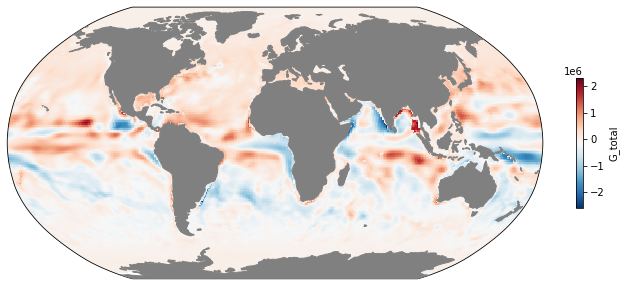

In [67]:
mapper(ds_out_full_depth.isel(time=100).G_total.rename({'tile':'face'}),cmap='RdBu_r')

In [55]:
# ds_out_full_depth.load()
ds_out_full_depth.compute()

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/srv/conda/envs/notebook/lib/python3.8/site

CancelledError: ('sum-aggregate-4bb204d8262649133a148693657705f7', 185, 0, 0, 0)

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [ ]:
1

## Save to zarr

In [ ]:
PANGEO_SCRATCH

In [ ]:
1

## Save to netcdf